In [ ]:
from multihead_TL_fctT import *
from multihead_model_bcT import *
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

### Transfer parameters

In [ ]:
L=2 #length of the domain
T=5 #time of the simulation
x_span = (0, L) #spatial domain
t_span = (0, T) #time domain

Nx= 100 #number of spatial points
Nt = 100 #number of time points
x, t, grid = generate_interior_tensor(IG=(Nx, Nt), x_span=(0, L), t_span=(0, T), require_grad=False)
# print(x.shape, type(t), type(grid))

# create a grid of points in space and time
X_grid = np.linspace(0, L, Nx)
t_eval = np.linspace(0, T, Nt)
mesh_x, mesh_t = np.meshgrid(X_grid, t_eval)

### Load the model

In [ ]:
def load_model(path, name):
    """
    Load a trained model from a specified path and filename.
    Assumes there model log is stored in 'training_log.json' in the same directory.
    """

    with open(f'{path}/training_log.json', 'r') as f:
        training_log = json.load(f)

    k = training_log['k']
    bias = training_log['bias']
    use_sine = training_log['use_sine']
    use_fourier = training_log['use_fourier']
    scale = training_log['scale']
    n_frequencies = training_log['n_frequencies']
    hidden_layers = training_log['hidden_layers']

    if use_fourier:
        print(k, bias, use_sine, use_fourier, scale, n_frequencies, hidden_layers)
        pinn = Multihead_model_fourier(k=k, bias=bias, use_sine=use_sine, use_fourier=use_fourier, scale=scale, n_frequencies=n_frequencies, HIDDEN_LAYERS=hidden_layers)
    else:
        print(k, bias, use_sine, use_fourier, hidden_layers)
        pinn = Multihead_model_fourier(k=k, bias=bias, HIDDEN_LAYERS=hidden_layers, hidden_act=[torch.sin, nn.Tanh(), nn.Tanh()] if use_sine else [nn.Tanh(), nn.Tanh(), nn.Tanh()])

    pinn.load_state_dict(torch.load(f'{path}/{name}'))

    return pinn, training_log


name = "overdamped_k15"

overdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
overdamped_name = f"model_{name}.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

model_name = 'Multi_4heads_iconly2_nobiaisbigT50000'
model, training_log, NN_solution = load_pretrain_model(model_name=model_name,mesh_grid = grid,Nx=Nx,Nt=Nt)

### Validate Multi-head

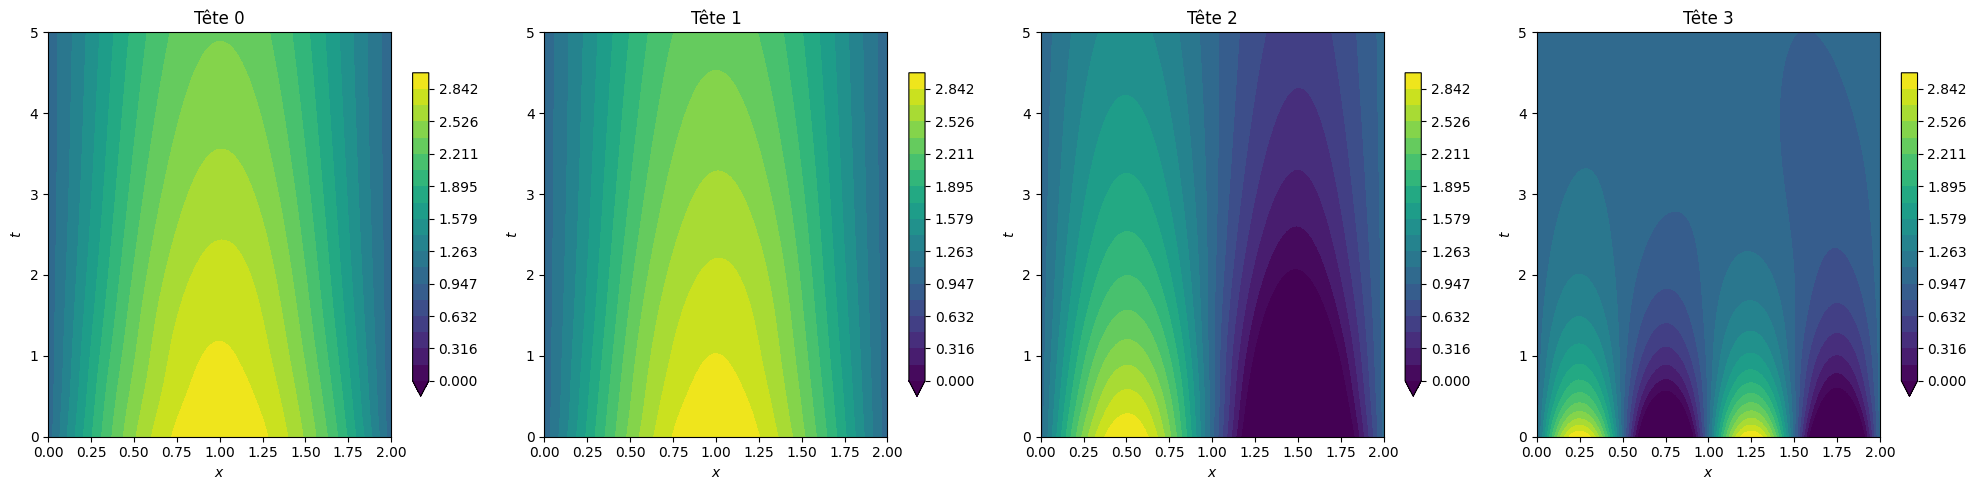

In [5]:
plot_4_heads(NN_solution, mesh_x, mesh_t, surface=False)

In [ ]:
H_dict = compute_H_dict(model = model,IG = (Nx,Nt), Nic = Nx,Nbc = Nt, bias = True, x_span= x_span,t_span= t_span,log = training_log)

Differentiating H w.r.t. x now...
Finished computing H2x.
Differentiating H w.r.t. t now...
Finished computing Ht


### Transfer for linear

In [ ]:
_, _, _ =compute_M(H_dict= H_dict,w_pde=1,w_ic=10,w_bc=10)



def ic_example(input):
    return ic_stepexp05(input) + echelon_square(1, 1.7, 0.7,20)(input)


ic = ic_example #ic_linear_small#ic_sin#ic_curve1#ic_curve#ic_linear#initial_condition2#initial_condition1#initial_condition05#constant_function(0)#ic_stepexp05
bcs = [constant_function(1), constant_function(0)]  # Define boundary conditions for the left and right boundaries


_, H_dict = compute_R_ic(H_dict,ic_function=ic, w_ic=10,log=training_log)#ic_function=ic_linear,
_,_,_,H_dict = compute_R_bcs(H_dict,boundary_functions=bcs ,w_bc=10, log=training_log)#boundary_values=training_log['equation_info']['boundary_values'][0]




lstsqM


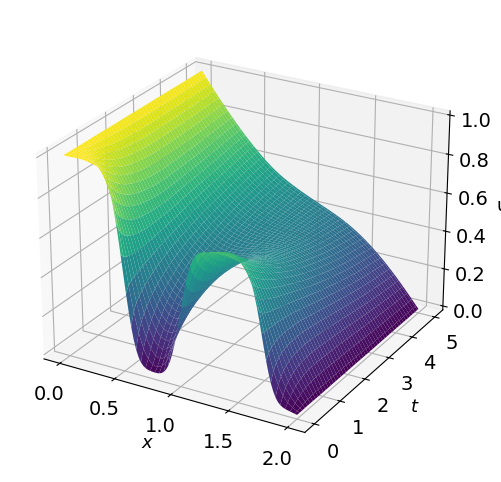

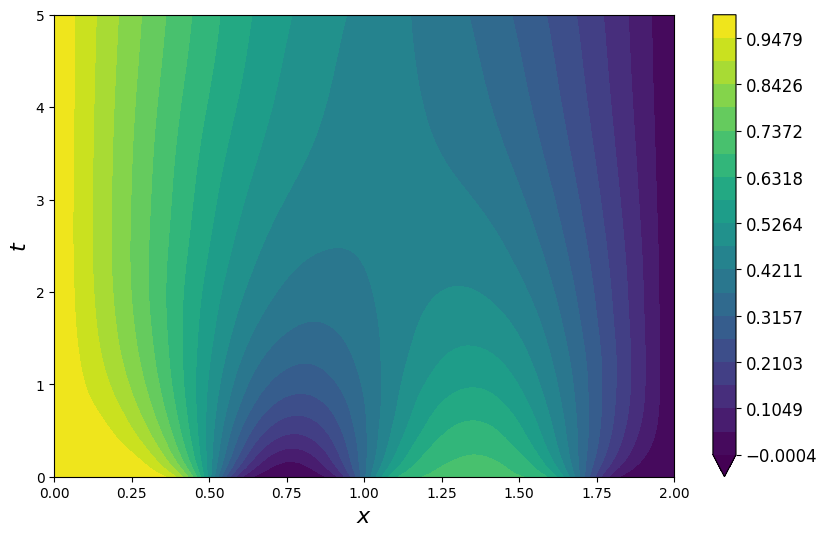

In [ ]:
input = torch.cat((x.unsqueeze(1), t.unsqueeze(1)), dim=1)  # Combine x and t into a single input tensor
W, computational_time = compute_TL_with_F(forcing_function=constant_function(0), w_pde= 1,H_dict= H_dict, input = input)

TL_solution = compute_solution(H_dict['H'], W, H_dict['N']).reshape(Nx, Nt)



# Plot the solution
plot_solution1(TL_solution, mesh_x= mesh_x, mesh_t = mesh_t)
plot_solution1(TL_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)

Error shape: (100, 100)
Error 0.0012260429816141622


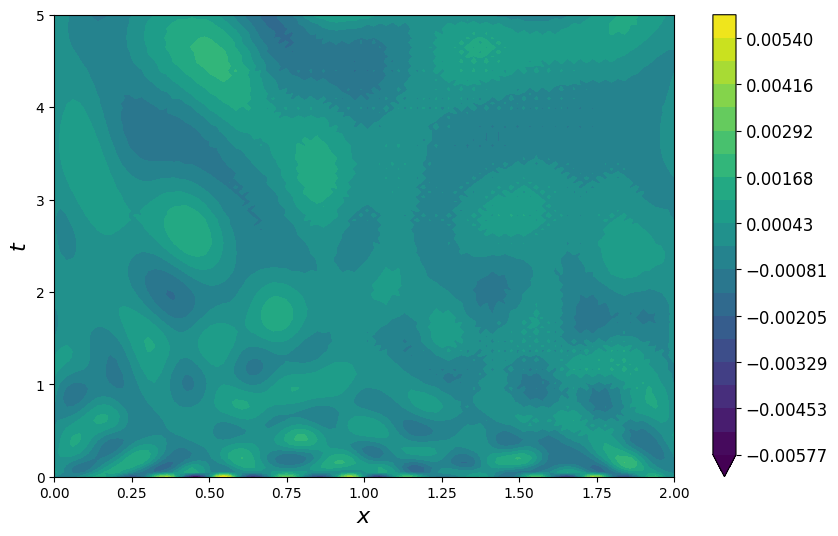

In [ ]:
error = TL_solution - np.load('sol_transfer_learning.npy')
print("Error shape:", error[0].shape)
print("Error", np.linalg.norm(error[0]) / np.linalg.norm(np.load('sol_transfer_learning.npy')[0]) ) #relative L2 norm
plot_solution1(error[0], mesh_x= mesh_x, mesh_t = mesh_t,surface=False)

### Solve the non-linear

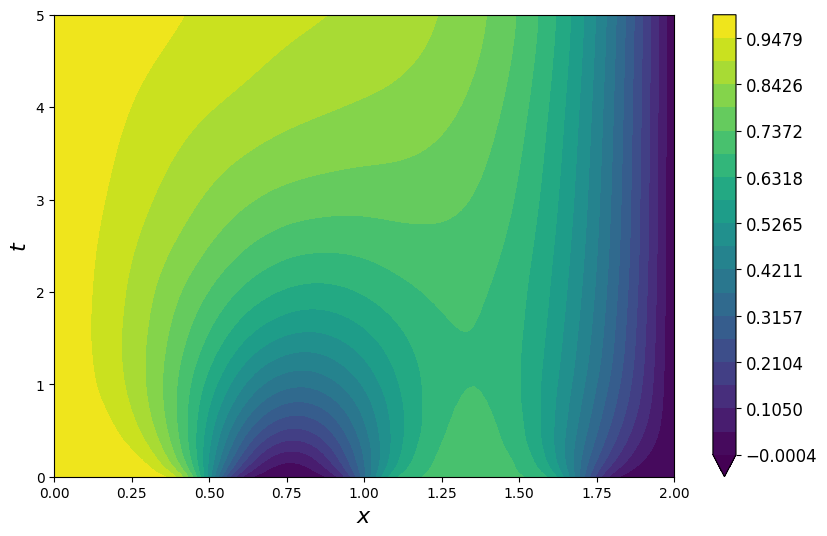

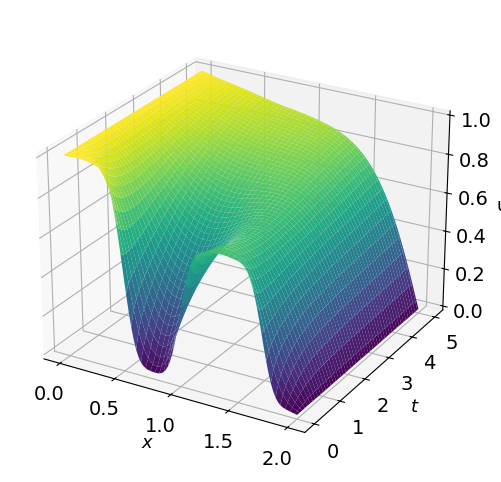

In [ ]:
epsilon = 0.5
p = 12 ###order of the expansion

def ic_example(input):
    return  ic_stepexp05(input) + echelon_square(1, 1.7, 0.7,20)(input) #

Polynomial = [[-1,1],[1,2]]

bcs=[constant_function(1),constant_function(0)]  # Define boundary conditions for the left and right boundaries
ic = ic_example#ic_stepexp05#constant_function(0)
forcing=constant_function(0)

NN_TL_pertubation_solution, _ = compute_perturbation_solution_polynomial_complete(p, epsilon,H_dict= H_dict, input=input,training_log= training_log, forcing=forcing,Polynomial=Polynomial,boundary_functions=bcs,ic_function=ic)

NN_TL_pertubation_solution = NN_TL_pertubation_solution.reshape(Nx, Nt)


plot_solution1(NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)
plot_solution1(NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=True,save_name = 'non_linear_1st_example')

### Influence of p

In [ ]:
def plot_solution2(solution, mesh_x, mesh_t, surface=True, path=None, title=None, rotation=(25, -60)):
    """
    args:
        solution (np.ndarray): shape (Nx, Nt) or (Nt, Nx)
        mesh_x, mesh_t (np.ndarray): meshgrids of size (Nx, Nt)
        surface (bool): True for 3D surface plot, False for contourf
        path (str): path to save the figure
        title (str): title of the plot
        rotation (tuple): (elev, azim) for 3D view
    """
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d' if surface else None)
    solution = solution.swapaxes(0, 1)  # shape (Nx, Nt)
    
    # Determine vmin/vmax from data
    vmin, vmax = solution.min(), solution.max()
    
    # Force symmetric or zero-centered range if needed
    vmin = min(vmin, 0)
    vmax = max(vmax, 0)
    
    # Generate evenly spaced ticks that always include 0
    num_ticks = 5
    ticks = np.linspace(vmin, vmax, num_ticks)

    if surface:
        surf = ax.plot_surface(mesh_x, mesh_t, solution, cmap='viridis', vmin=vmin, vmax=vmax)
        ax.view_init(rotation[0], rotation[1])
        ax.set_xlabel("$x$", fontsize=22)
        ax.set_ylabel("$t$", fontsize=22)
        ax.set_zlabel("u", fontsize=2)
        
        # Colorbar with fixed ticks
        cbar = fig.colorbar(surf, ax=ax, shrink=0.7, ticks=ticks)
        cbar.set_label("u", fontsize=13)
        cbar.ax.tick_params(labelsize=22)
    
    else:
        levels = np.linspace(vmin, vmax, 20)
        Cs = ax.contourf(mesh_x, mesh_t, solution, levels=levels, cmap='viridis', vmin=vmin, vmax=vmax, extend='both')
        cbar = fig.colorbar(Cs, ax=ax, ticks=ticks)
        cbar.ax.tick_params(labelsize=12)
        ax.set_xlabel("$x$", fontsize=22)
        ax.set_ylabel("$t$", fontsize=22)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(labelsize=15)


    if path is not None:
        fig.savefig(path, bbox_inches='tight')
    else:
        plt.show()


In [ ]:
solution_nl = np.load('sol_nonlinear_example.npy')

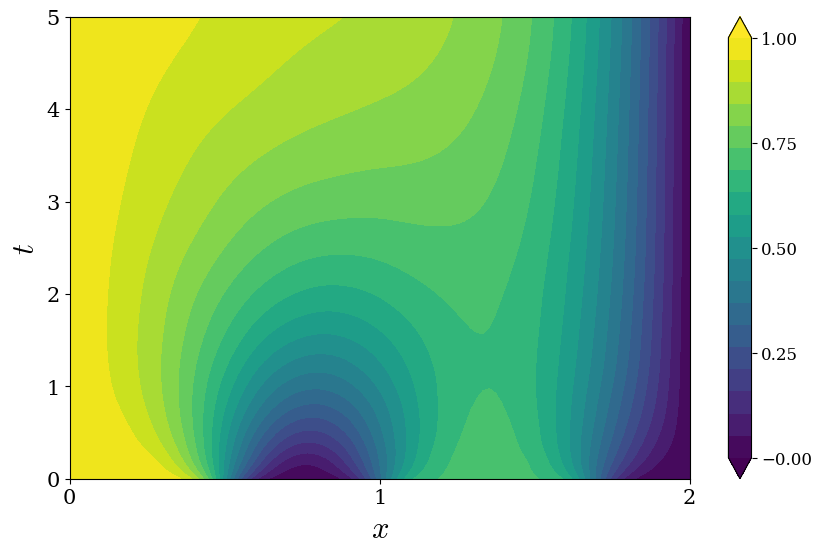

In [ ]:
plot_solution2(NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)

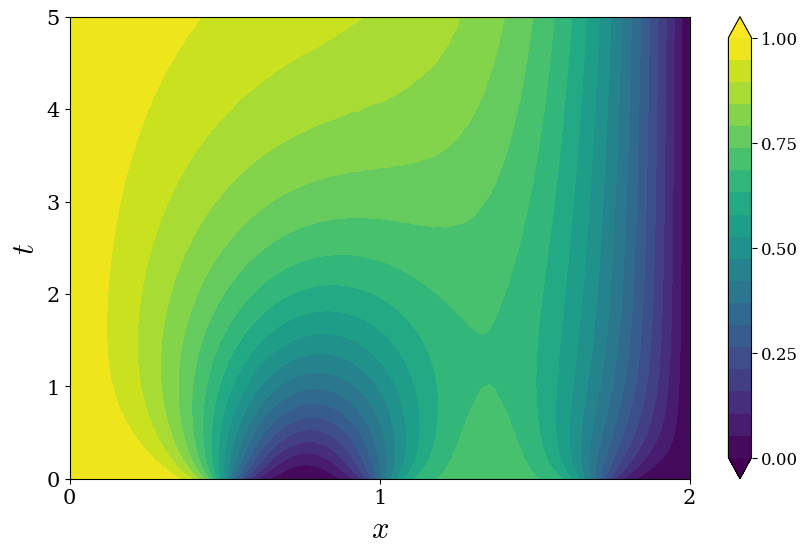

In [ ]:
plot_solution2(solution_nl[0], mesh_x= mesh_x, mesh_t = mesh_t, surface=False)

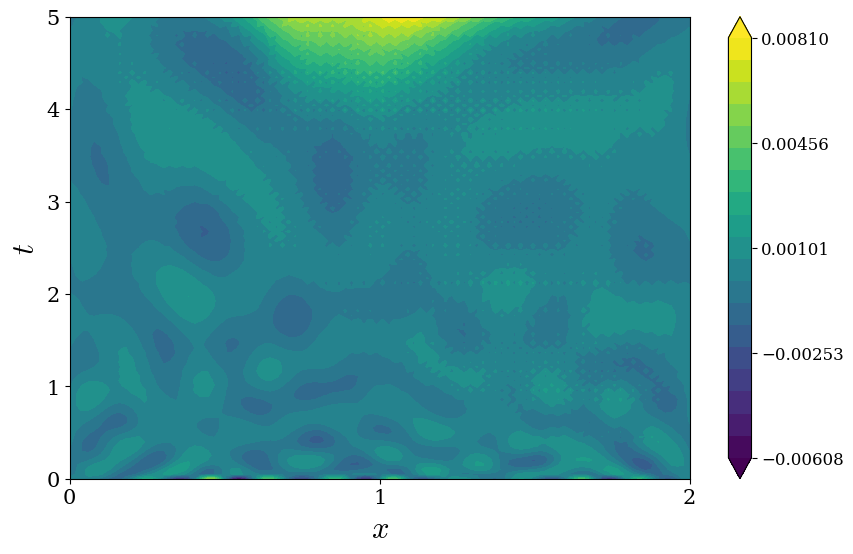

In [ ]:
plot_solution2(solution_nl[0] - NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)

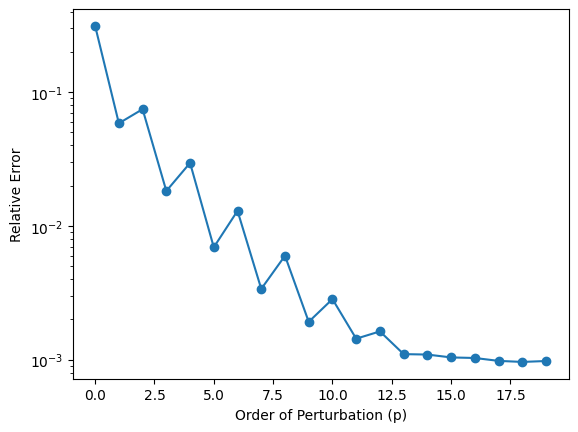

In [ ]:
p_list = [i for i in range(20)]  # List of orders of expansion to test
pertubation_error_for_p_complete(p_list=p_list, forcing=forcing, H_dict=H_dict, input=input, training_log=training_log, solution=solution_nl, epsilon=epsilon,Polynomial=Polynomial,boundary_functions=bcs,ic_function=ic,save_name='Error of pertubation solution for different orders of expansion')


### Other polynomial

##### -u(1-u^10)

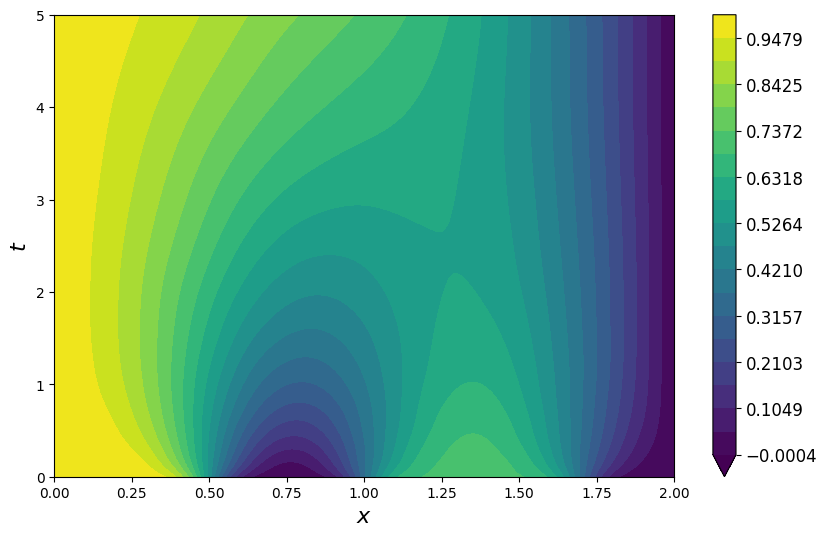

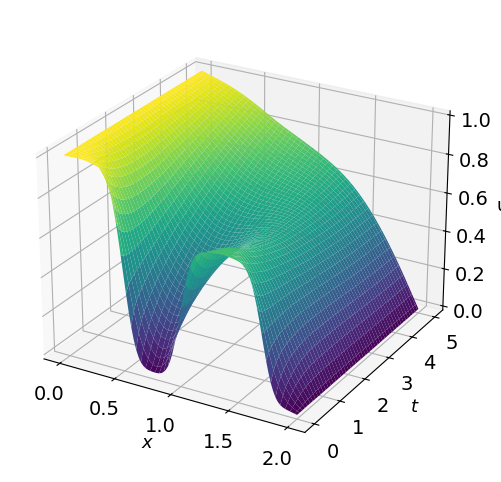

In [ ]:
epsilon = 0.1
p = 10 ###order of the expansion

def ic_example(input):
    return ic_stepexp05(input) + echelon_square(1, 1.7, 0.7,20)(input)

Polynomial = [[-1,1],[1,11]]

bcs=[constant_function(1),constant_function(0)]  # Define boundary conditions for the left and right boundaries
ic = ic_example#ic_stepexp05#constant_function(0)
forcing=constant_function(0)

NN_TL_pertubation_solution, _ = compute_perturbation_solution_polynomial_complete(p, epsilon,H_dict= H_dict, input=input,training_log= training_log, forcing=forcing,Polynomial=Polynomial,boundary_functions=bcs,ic_function=ic)

NN_TL_pertubation_solution2 = NN_TL_pertubation_solution.reshape(Nx, Nt)

plot_solution1(NN_TL_pertubation_solution2, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)
plot_solution1(NN_TL_pertubation_solution2, mesh_x= mesh_x, mesh_t = mesh_t, surface=True)

##### -u^10(1-u)

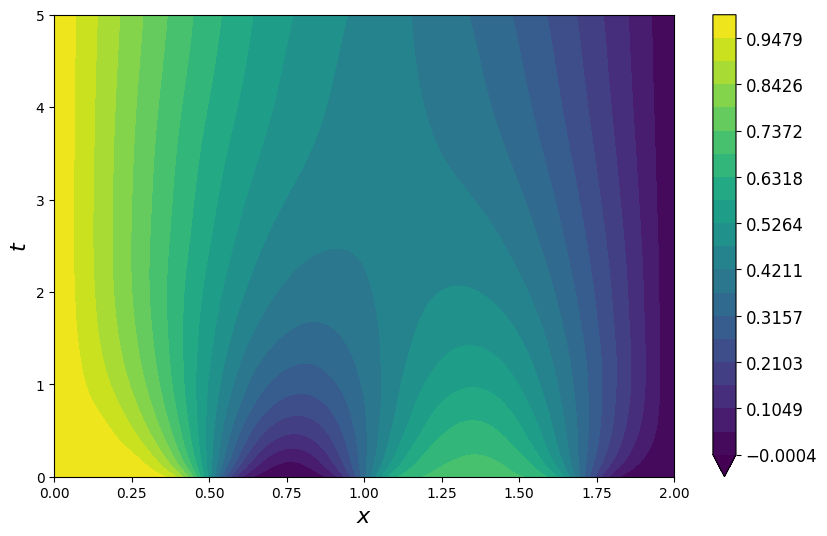

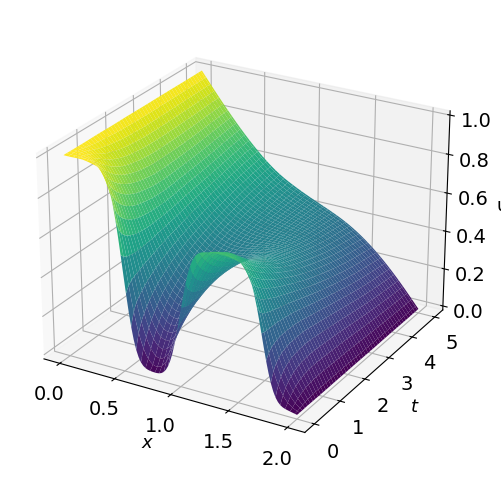

In [ ]:
epsilon = 0.1
p = 10 ###order of the expansion

def ic_example(input):
    return ic_stepexp05(input) + echelon_square(1, 1.7, 0.7,20)(input)

Polynomial = [[-1,10],[1,11]]

bcs=[constant_function(1),constant_function(0)]  # Define boundary conditions for the left and right boundaries
ic = ic_example#ic_stepexp05#constant_function(0)
forcing=constant_function(0)

NN_TL_pertubation_solution, _ = compute_perturbation_solution_polynomial_complete(p, epsilon,H_dict= H_dict, input=input,training_log= training_log, forcing=forcing,Polynomial=Polynomial,boundary_functions=bcs,ic_function=ic)

NN_TL_pertubation_solution1 = NN_TL_pertubation_solution.reshape(Nx, Nt)

plot_solution1(NN_TL_pertubation_solution1, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)
plot_solution1(NN_TL_pertubation_solution1, mesh_x= mesh_x, mesh_t = mesh_t, surface=True)

In [ ]:
numerical_solutions = np.load('sol_nonlinear_n2_n1.npy')

In [ ]:
print(np.linalg.norm(numerical_solutions[0] - NN_TL_pertubation_solution2)/np.linalg.norm(numerical_solutions[0]))
print(np.linalg.norm(numerical_solutions[1] - NN_TL_pertubation_solution1)/np.linalg.norm(numerical_solutions[1]))

0.0010522760804866852
0.0012244897847007955


### various condition

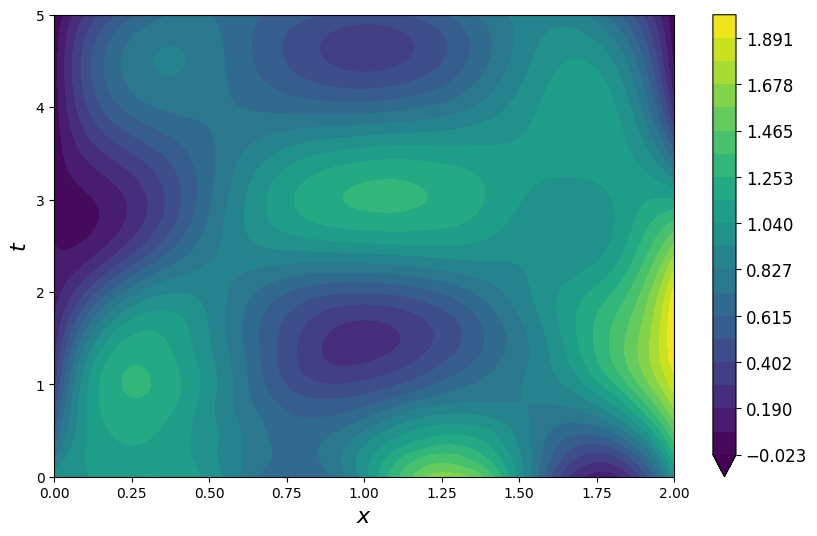

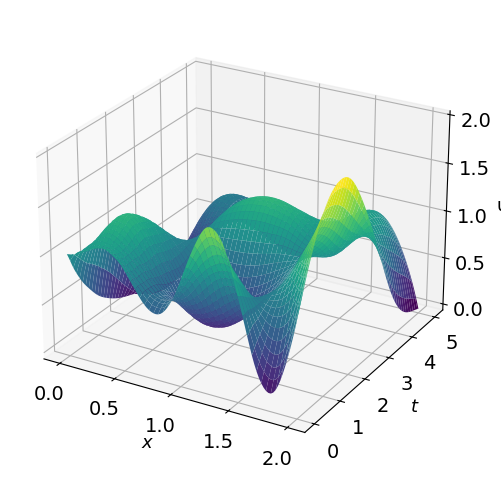

In [ ]:
epsilon = 0.3
p = 10 ###order of the expansion

def bc_various0(input):
    t = input[:, 1].unsqueeze(1)
    return torch.exp(-t)

def bc_various1(input):
    t = input[:, 1].unsqueeze(1)
    return 1+ torch.sin(t)

def ic_various(input):
    x = input[:, 0].unsqueeze(1)
    return 1 + 0.5*x*torch.sin(2*torch.pi*x)

Polynomial = [[-1,2],[1,3]]

bcs=[bc_various0,bc_various1]  # Define boundary conditions for the left and right boundaries
ic = ic_various#ic_stepexp05#constant_function(0)
forcing= forcing_sin2cos3

NN_TL_pertubation_solution, _ = compute_perturbation_solution_polynomial_complete(p, epsilon,H_dict= H_dict, input=input,training_log= training_log, forcing=forcing,Polynomial=Polynomial,boundary_functions=bcs,ic_function=ic)

NN_TL_pertubation_solution_various = NN_TL_pertubation_solution.reshape(Nx, Nt)

plot_solution1(NN_TL_pertubation_solution_various, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)
plot_solution1(NN_TL_pertubation_solution_various, mesh_x= mesh_x, mesh_t = mesh_t, surface=True)

In [ ]:
numerical_solution_various = np.load('sol_nonlinear_various.npy')

In [ ]:
print(np.linalg.norm(numerical_solution_various - NN_TL_pertubation_solution_various)/np.linalg.norm(numerical_solution_various))

0.019202985635378055


### Error in term of epsilon

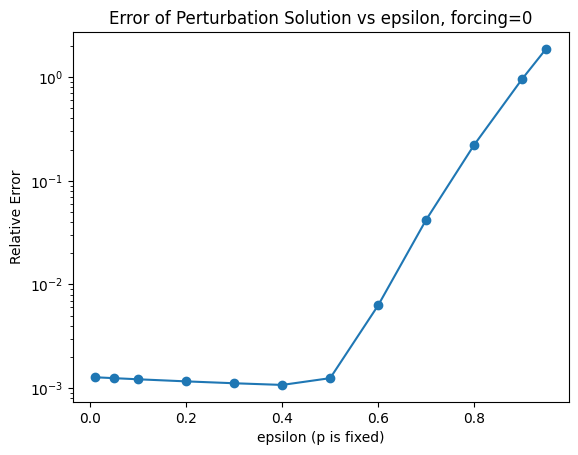

In [ ]:
epsilons = [0.01,0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,0.95]  # Different epsilon values for testing
p = 12 ###order of the expansion

def ic_example(input):
    return  ic_stepexp05(input) + echelon_square(1, 1.5, 0.7,20)(input) #

Polynomial = [[-1,1],[1,2]]

bcs=[constant_function(1),constant_function(0)]  # Define boundary conditions for the left and right boundaries
ic = ic_example#ic_stepexp05#constant_function(0)
forcing=constant_function(0)

numerical_solutions = np.load('sol_nonlinear_error_forcing0.npy')   

error_for_epsilons(p,epsilons,numerical_solutions , forcing, H_dict, input, training_log, Polynomial,boundary_functions= bcs, ic_function = ic,title='Error of Perturbation Solution vs epsilon, forcing=0')

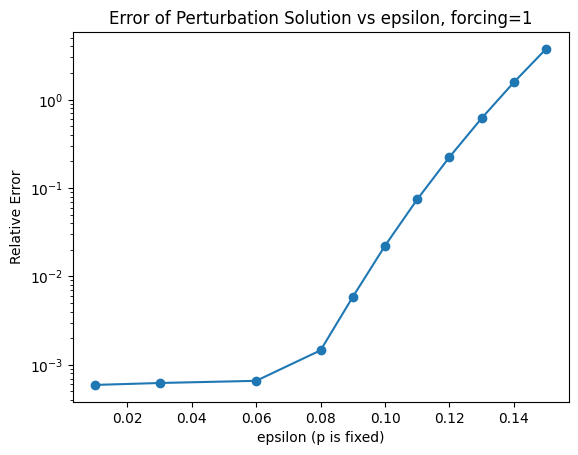

In [ ]:
epsilons = [0.01,0.03,0.06,0.08, 0.09, 0.1, 0.11, 0.12,0.13,0.14,0.15] # #Different epsilon values for testing
p = 12 ###order of the expansion

def ic_example(input):
    return  ic_stepexp05(input) + echelon_square(1, 1.5, 0.7,20)(input) #

Polynomial = [[-1,1],[1,2]]

bcs=[constant_function(1),constant_function(0)]  # Define boundary conditions for the left and right boundaries
ic = ic_example#ic_stepexp05#constant_function(0)
forcing=constant_function(1)

numerical_solutions = np.load('sol_nonlinear_error_forcing1.npy')   

error_for_epsilons(p,epsilons,numerical_solutions , forcing, H_dict, input, training_log, Polynomial,boundary_functions= bcs, ic_function = ic,title='Error of Perturbation Solution vs epsilon, forcing=1')

### Pertubation with functions

In [ ]:
def taylor_sin(n):
    """
    Génère le polynôme de Taylor de sin(x) tronqué à l'ordre n.
    
    Args:
        n (int): L'ordre de troncature du développement de Taylor.
        
    Returns:
        list: Une liste de listes de la forme [[a_k, k]], où a_k est le coefficient et k la puissance.
              Les coefficients nuls ne sont pas inclus.
    """
    taylor = []
    for k in range(n + 1):
        if k % 2 == 1:  # seuls les termes impairs sont non nuls
            a_k = (-1)**((k - 1) // 2) / math.factorial(k)
            taylor.append([a_k, k])
    return taylor

def taylor_cos(n):
    """
    Génère le polynôme de Taylor de sin(x) tronqué à l'ordre n.
    
    Args:
        n (int): L'ordre de troncature du développement de Taylor.
        
    Returns:
        list: Une liste de listes de la forme [[a_k, k]], où a_k est le coefficient et k la puissance.
              Les coefficients nuls ne sont pas inclus.
    """
    taylor = []
    for k in range(n + 1):
        if k % 2 == 0:  # seuls les termes impairs sont non nuls
            a_k = (-1)**((k - 1) // 2)*(3**k) / math.factorial(k)
            taylor.append([a_k, k])
    return taylor

def taylor_arctan(n):
    taylor = []
    for k in range(n + 1):
        if k % 2 == 1:  # seuls les termes impairs sont non nuls
            a_k = (-1)**((k - 1) // 2) / k
            taylor.append([a_k, k])

    return taylor

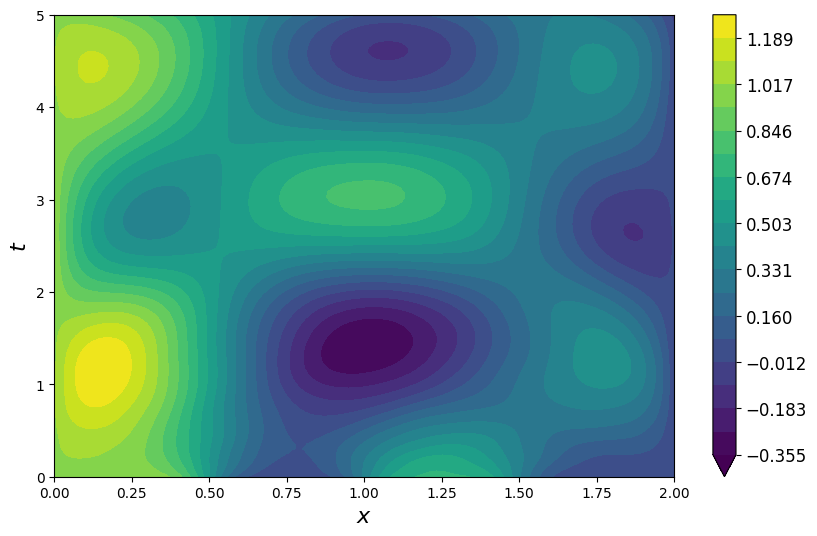

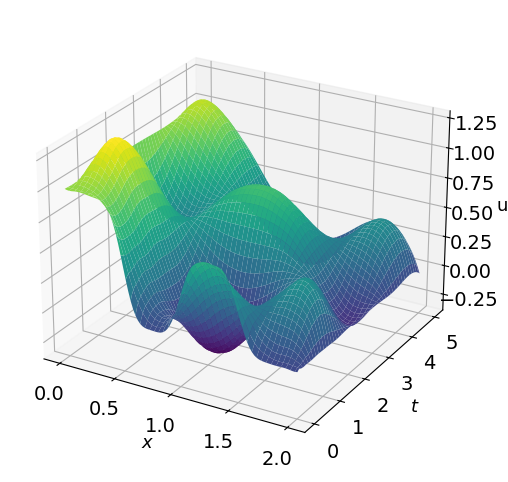

In [ ]:
epsilon = 0.1
p = 10  ###order of the expansion


Polynomial = taylor_cos(12)#[[-1,2],[1,3]]

def ic_example(input):
    return  ic_stepexp05(input) + echelon_square(1, 1.5, 0.7,20)(input) #

bcs=[constant_function(1),constant_function(0)]  # Define boundary conditions for the left and right boundaries
ic = ic_example#ic_stepexp05#constant_function(0)

forcing= forcing_sin2cos3

NN_TL_pertubation_solution, _ = compute_perturbation_solution_polynomial_complete(p, epsilon,H_dict= H_dict, input=input,training_log= training_log, forcing=forcing,Polynomial=Polynomial,boundary_functions=bcs,ic_function=ic)

NN_TL_pertubation_solution = NN_TL_pertubation_solution.reshape(Nx, Nt)


plot_solution1(NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)
plot_solution1(NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=True)

### error for the truncated 

In [ ]:
numerical_solution = np.load('sol_nonlinear_perturbation_function_sin.npy')

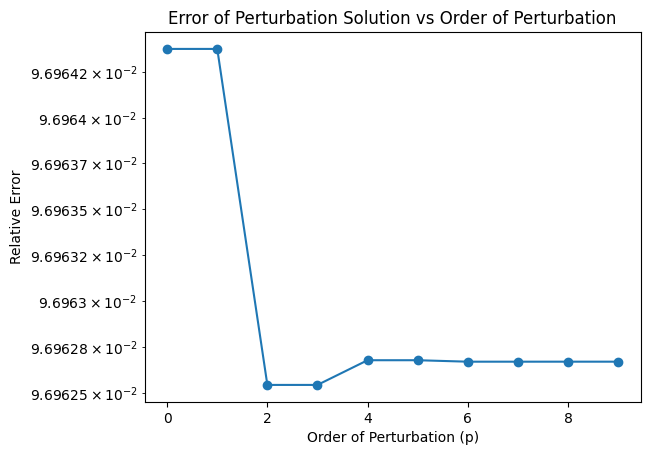

In [ ]:
epsilon = 0.02
p = 10  ###order of the expansion


Polynomials = [taylor_cos(i) for i in range(10,20)]#[[-1,2],[1,3]]

def ic_example(input):
    return  ic_stepexp05(input) + echelon_square(1, 1.5, 0.7,20)(input) #

bcs=[constant_function(1),constant_function(0)]  # Define boundary conditions for the left and right boundaries
ic = ic_example#ic_stepexp05#constant_function(0)
forcing= forcing_sin2cos3 

pertubation_error_for_truncated_function_complete(p, forcing=forcing, H_dict=H_dict, input=input, training_log=training_log, solution=numerical_solution, epsilon=epsilon,Polynomials=Polynomials,boundary_functions=bcs,ic_function=ic)
